To zip datafolders:

* zip -r -X zipname.zip images data.csv

________
CH Script

In [ ]:
!python detection_cnn.py --data_file ../data/oxfordpets/data.csv \
--epochs 10 \
--batch_size 28 \
--shape 96 \
--workers 12 \
--patience_stop 20 \
--patience_lr 10 \
--preprocess_for vgg16 \
--local

In [1]:
!zip -r -X detection_model.zip detection_cnn.py load_data.py

updating: detection_cnn.py (deflated 73%)
updating: load_data.py (deflated 77%)


In [5]:
!zip -r -X detection_model_label.zip detection_cnn_label.py load_data_label.py

updating: detection_cnn_label.py (deflated 72%)
updating: load_data_label.py (deflated 78%)


_____

### Setup

In [1]:
from ibmcloud_api import IBMCloudAPI
from keras.models import load_model
import keras.backend as K
from load_data import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import json

def predict_and_scale(model, x_scaled, x_og):
    y_pred_scaled = model.predict(x_scaled)
    y_pred = np.zeros(y_pred_scaled.shape)
    for i, bbox in enumerate(y_pred_scaled):
        img_scaled = x_scaled[i]
        img_og = x_og[i]
        sh, sw = img_scaled.shape[:2]
        ogh, ogw = img_og.shape[:2]
        
        sxm0, sym0, sxm1, sym1 = bbox
        sxm0 = int(sxm0 * ogw / sw)
        sym0 = int(sym0 * ogh / sh)
        sxm1 = int(sxm1 * ogw / sw)
        sym1 = int(sym1 * ogh / sh)
        sbwm, sbhm = sxm1-sxm0, sym1-sym0
        
        y_pred[i] = [sxm0, sym0, sxm1, sym1]
        
    return y_pred

def plot_with_bboxes(model, img, bbox):
    x0, y0, x1, y1 = bbox
    w, h = x1-x0, y1-y0
    
    predbox = model.predict(np.expand_dims(img, 0))[0]
    xm0, ym0, xm1, ym1 = predbox
    xm0, ym0, xm1, ym1 = int(xm0), int(ym0), int(xm1), int(ym1)
    wm, hm = xm1-xm0, ym1-ym0

    ax = plt.subplot(111)
    ax.imshow(img)
    rect_true = plt.Rectangle((x0, y0), w, h, linewidth=3, edgecolor="green", facecolor="none")
    rect_pred = plt.Rectangle((xm0, ym0), wm, hm, linewidth=3, edgecolor="red", facecolor="none")
    ax.add_patch(rect_true)
    ax.add_patch(rect_pred)
    plt.show()
    print(bbox)
    print([xm0, ym0, xm1, ym1])
    
def plot_test_image(model, x_scaled, y_scaled, x_og, y_og):
    sh, sw = x_scaled.shape[:2]
    ogh, ogw = x_og.shape[:2]
    y_pred_scaled = model.predict(np.expand_dims(x_scaled, 0))[0]
    
    x0, y0, x1, y1 = y_og
    bw, bh = x1-x0, y1-y0
    
    sxm0, sym0, sxm1, sym1 = y_pred_scaled
    sxm0 = int(sxm0 * ogw / sw)
    sym0 = int(sym0 * ogh / sh)
    sxm1 = int(sxm1 * ogw / sw)
    sym1 = int(sym1 * ogh / sh)
    sbwm, sbhm = sxm1-sxm0, sym1-sym0
    
    ax = plt.subplot(111)
    ax.imshow(x_og)
    rect_true = plt.Rectangle((x0, y0), bw, bh, linewidth=3, edgecolor="green", facecolor="none")
    rect_pred = plt.Rectangle((sxm0, sym0), sbwm, sbhm, linewidth=3, edgecolor="red", facecolor="none")
    
    ax.add_patch(rect_true)
    ax.add_patch(rect_pred)
    plt.show()
    print(y_og)
    print([sxm0, sym0, sxm1, sym1])

def np_iou(y_true, y_pred):
    x11, y11, x12, y12 = y_true[:,0], y_true[:,1], y_true[:,2], y_true[:,3]
    x21, y21, x22, y22 = y_pred[:,0], y_pred[:,1], y_pred[:,2], y_pred[:,3]

    xI1 = np.maximum(x11, np.transpose(x21))
    xI2 = np.minimum(x12, np.transpose(x22))

    yI1 = np.maximum(y11, np.transpose(y21))
    yI2 = np.minimum(y12, np.transpose(y22))

    wI = np.maximum((xI2 - xI1), 0)
    hI = np.maximum((yI2 - yI1), 0)

    inter_area = wI * hI

    y_true_area = (x12 - x11) * (y12 - y11)
    y_pred_area = (x22 - x21) * (y22 - y21)

    union = (y_true_area + np.transpose(y_pred_area)) - inter_area
    
    ious = inter_area / (union + K.epsilon())
    return np.mean(ious)


Using TensorFlow backend.


### IBM Cloud Setup

In [2]:
cos_credentials = {
  "apikey": "ftIWPpG8LpqDtntew59ckZcQs-qbEER1oJHWgVI2rHX3",
  "cos_hmac_keys": {
    "access_key_id": "db63540372394a2bb6e4270bca041bb8",
    "secret_access_key": "293fce31ec8287a4f1ffdd00ef02638047112dd957db4c0c"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/7fec468bf3b9a2181d714162d559c6e4:ab8fce54-b276-43ff-b3ce-8d04d858f79f::",
  "iam_apikey_name": "auto-generated-apikey-db635403-7239-4a2b-b6e4-270bca041bb8",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/7fec468bf3b9a2181d714162d559c6e4::serviceid:ServiceId-a76bc3a3-acfd-466c-9009-68028fc914be",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/7fec468bf3b9a2181d714162d559c6e4:ab8fce54-b276-43ff-b3ce-8d04d858f79f::"
}
cos_service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

wml_credentials = {
  "apikey": "z_xmW8qw7lU3u4yNxS_wsUD-1EtgW48JKw9n9sQsS7hF",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/7fec468bf3b9a2181d714162d559c6e4:3769e702-a12f-4a0c-bac0-19656fcd56ff::",
  "iam_apikey_name": "auto-generated-apikey-6a740a92-1aae-489f-97af-fcac2079f94c",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/7fec468bf3b9a2181d714162d559c6e4::serviceid:ServiceId-cb89dede-3126-4699-aaa2-5956523d4527",
  "instance_id": "3769e702-a12f-4a0c-bac0-19656fcd56ff",
  "password": "675440b4-85ab-4198-bf68-753e4b4495f0",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "6a740a92-1aae-489f-97af-fcac2079f94c"
}

api = IBMCloudAPI(cos_credentials, cos_service_endpoint, wml_credentials)

#### Data

In [3]:
dataset = "oxfordpets"
#dataset = "tudarmstadt"
data_bucket = dataset + "-data"
result_bucket = dataset + "-result"

data_bucket_endpoint_private = "s3-api.us-geo.objectstorage.service.networklayer.com"
data_bucket_endpoint_public = "s3-api.us-geo.objectstorage.softlayer.net"
result_bucket_endpoint_private = "s3-api.us-geo.objectstorage.service.networklayer.com"
result_bucket_endpoint_public = "s3-api.us-geo.objectstorage.softlayer.net"

In [4]:
buckets = {
    "data_bucket":{
        "name":data_bucket,
        "endpoint":data_bucket_endpoint_private
    },
    "result_bucket":{
        "name":result_bucket,
        "endpoint":result_bucket_endpoint_private
    }
}

### Training

In [5]:
#definition_name = "Detection-FCN-CLF-BBOX-{}-IOU".format(dataset)
definition_name = "VGG16-FCN-BBOX-{}-s96-h0".format(dataset)

definition_uid, run_uid = api.train_in_cloud(
    "detection_model.zip",
    buckets,
    definition_name,
    asynchronous=True,
    log=False,
    command=[
        "python detection_cnn.py",
        "--epochs 200",
        "--batch_size 32",
        "--preprocess_for vgg16",
        "--workers 100",
        "--shape 96",
        "--patience_stop 50",
        "--patience_lr 10"
    ]
)

definition_uid:  5966eba5-32f3-4820-b5c3-eb28bc989732
Run uid:  model-n7wxx5l7
Run details:
{
 "metadata": {
  "guid": "model-n7wxx5l7",
  "url": "/v3/models/model-n7wxx5l7",
  "created_at": "2018-12-14T09:05:26Z",
  "modified_at": "2018-12-14T09:05:26Z"
 },
 "entity": {
  "model_definition": {
   "framework": {
    "name": "tensorflow",
    "version": "1.5"
   },
   "name": "(Training) VGG16-FCN-BBOX-oxfordpets-s96-h0",
   "definition_href": "https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/5966eba5-32f3-4820-b5c3-eb28bc989732",
   "execution": {
    "command": "python detection_cnn.py --epochs 200 --batch_size 32 --preprocess_for vgg16 --workers 100 --shape 96 --patience_stop 50 --patience_lr 10",
    "compute_configuration": {
     "name": "k80"
    }
   }
  },
  "training_data_reference": {
   "type": "s3",
   "connection": {
    "endpoint_url": "s3-api.us-geo.objectstorage.service.networklayer.com",
    "aws_access_key_id": "db63540372394a2bb6e4270bca041bb8",
  

In [15]:
status = api.training_status(run_uid)

print(status["state"])
for i in range(0, len(status["metrics"])-1, 2):
    it = status["metrics"][i]["iteration"]
    val, train = status["metrics"][i]["values"][0]["value"], status["metrics"][i+1]["values"][0]["value"]
    print("Epoch {}\n- Training loss: {:.6f} - Validation loss: {:.6f}".format(it, train, val))

completed


##### Logs

In [16]:
api.download_latest_training_log(result_bucket, "logs/training-log-{}.txt".format(definition_name))

downloading training-q-xLsUPig/learner-1/training-log.txt to logs/training-log-VGG16-FCN-BBOX-oxfordpets-s96-h0.txt... done


In [ ]:
!cat logs/training-log-VGG16-FCN-BBOX-oxfordpets-s96-h0.txt

### Predict a test sample

In [8]:
model_path = "models/" + definition_name
api.download_best_checkpoint(result_bucket, model_path + ".modelckpt")
#api.download_latest_model(result_bucket, model_path + ".model")

downloading _wml_checkpoints/model-27-0.5960411.h5 to models/ResNet50-FCN-BBOX-oxfordpets-h2x128-r01l1.modelckpt... done


In [7]:
from detection_cnn import iou
data = load_dataset("../data/{}/data.csv".format(dataset))
model = load_model(model_path + ".modelckpt", custom_objects={'iou': iou})

In [8]:
testgen = data.test.set_generator(shape=(224,224,3),
                        batch_size=32,
                        preprocess_for="resnet50"
                       )
x_scaled, bboxes_scaled, x_og, bboxes_og = testgen[0]

In [9]:
#model.evaluate(x_scaled, {"box_head":bboxes_scaled, "class_head":labels})
model.evaluate(x_scaled, bboxes_scaled)

32/32 [==============================] - 7s 206ms/step


[274.75152587890625, 0.5795769691467285]

In [10]:
y_pred = predict_and_scale(model, x_scaled, x_og)
np_iou(np.array(bboxes_og).astype(np.float32), np.array(y_pred).astype(np.float32))

0.58708775

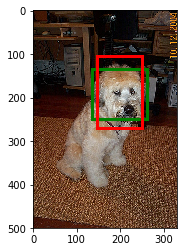

2018-12-14 07:42:35,832 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[135, 134, 261, 249]
[147, 104, 250, 270]


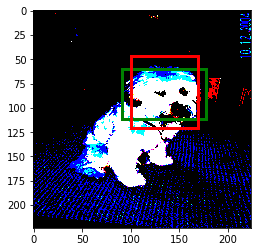

[ 91.  60. 177. 111.]
[100, 47, 169, 121]


In [22]:
i = 11
plot_test_image(model, x_scaled[i], bboxes_scaled[i], x_og[i], bboxes_og[i])
plot_with_bboxes(model, x_scaled[i], bboxes_scaled[i])

### Deploy

### Warning: Delete definitions

In [8]:
api.cancel_training_run(run_uid)
api.delete_model_definition(definition_uid)
api.delete_training_definition(run_uid)
api.empty_cos_bucket(result_bucket)